In [33]:
# =========================================================
# Clean Start: Olist 9 CSV 로드 + 복사본 생성 + EDA 유틸 (메모리만 사용)
# - 저장 없음: 모든 처리는 DataFrame 변수로만 유지
# - 경로: 노트북 폴더 우선, 없으면 /mnt/data 폴더에서 로드
# - 원본(raw_*)과 작업용(df_*) 분리 (raw_* -> df_* = .copy())
# =========================================================

# [기본 세팅] ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# [경로 유틸] ------------------------------------------------
import os

def _path(*candidates):
    """여러 경로 후보 중 존재하는 첫 번째를 반환."""
    for p in candidates:
        if p and os.path.exists(p):
            return p
    return None

# [파일 경로 확인] --------------------------------------------
FN = {
    "orders": "olist_orders_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "order_payments": "olist_order_payments_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv",
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "category_tr": "product_category_name_translation.csv",
}

def resolve_path(filename):
    here = os.path.join(".", filename)
    data = os.path.join("/mnt/data", filename)
    p = _path(here, data)
    if p is None:
        raise FileNotFoundError(f"파일이 보이지 않습니다: {filename} (현재폴더 또는 /mnt/data)")
    return p

# [로더] ------------------------------------------------------
def load_all():
    # parse_dates 사전 지정
    orders = pd.read_csv(
        resolve_path(FN["orders"]),
        parse_dates=[
            "order_purchase_timestamp",
            "order_approved_at",
            "order_delivered_carrier_date",
            "order_delivered_customer_date",
            "order_estimated_delivery_date",
        ],
        low_memory=False,
    )
    order_items = pd.read_csv(
        resolve_path(FN["order_items"]),
        parse_dates=["shipping_limit_date"],
        low_memory=False,
    )
    order_payments = pd.read_csv(resolve_path(FN["order_payments"]), low_memory=False)
    order_reviews = pd.read_csv(
        resolve_path(FN["order_reviews"]),
        parse_dates=["review_creation_date", "review_answer_timestamp"],
        low_memory=False,
    )
    customers = pd.read_csv(resolve_path(FN["customers"]), low_memory=False)
    geolocation = pd.read_csv(resolve_path(FN["geolocation"]), low_memory=False)
    products = pd.read_csv(resolve_path(FN["products"]), low_memory=False)
    sellers = pd.read_csv(resolve_path(FN["sellers"]), low_memory=False)
    category_tr = pd.read_csv(resolve_path(FN["category_tr"]), low_memory=False)

    # dtype 통일(문자 ID/ZIP은 문자열로 유지)
    def _as_str(df, cols):
        for c in cols:
            if c in df.columns:
                df[c] = df[c].astype(str)
        return df

    orders = _as_str(orders, ["order_id", "customer_id"])
    order_items = _as_str(order_items, ["order_id", "product_id", "seller_id"])
    order_payments = _as_str(order_payments, ["order_id", "payment_type"])
    order_reviews = _as_str(order_reviews, ["review_id", "order_id"])
    customers = _as_str(customers, ["customer_id", "customer_unique_id"])
    # ZIP prefix는 0-패딩 가능성이 있으므로 문자열 유지
    customers = _as_str(customers, ["customer_zip_code_prefix"])
    geolocation = _as_str(geolocation, ["geolocation_zip_code_prefix"])
    products = _as_str(products, ["product_id", "product_category_name"])
    sellers = _as_str(sellers, ["seller_id", "seller_zip_code_prefix"])
    category_tr = _as_str(category_tr, ["product_category_name", "product_category_name_english"])

    # 숫자 컬럼 보정
    if "price" in order_items.columns:
        order_items["price"] = pd.to_numeric(order_items["price"], errors="coerce")
    if "freight_value" in order_items.columns:
        order_items["freight_value"] = pd.to_numeric(order_items["freight_value"], errors="coerce")
    if "payment_value" in order_payments.columns:
        order_payments["payment_value"] = pd.to_numeric(order_payments["payment_value"], errors="coerce")
    if "payment_installments" in order_payments.columns:
        order_payments["payment_installments"] = pd.to_numeric(order_payments["payment_installments"], errors="coerce")

    raw = {
        "orders": orders,
        "order_items": order_items,
        "order_payments": order_payments,
        "order_reviews": order_reviews,
        "customers": customers,
        "geolocation": geolocation,
        "products": products,
        "sellers": sellers,
        "category_tr": category_tr,
    }
    return raw

raw = load_all()

# 작업용 복사본(DataFrame 메모리에서만 사용)
df_orders         = raw["orders"].copy()
df_order_items    = raw["order_items"].copy()
df_payments       = raw["order_payments"].copy()
df_reviews        = raw["order_reviews"].copy()
df_customers      = raw["customers"].copy()
df_geolocation    = raw["geolocation"].copy()
df_products       = raw["products"].copy()
df_sellers        = raw["sellers"].copy()
df_category_tr    = raw["category_tr"].copy()

# [EDA 유틸] --------------------------------------------------
def quick_shape_info(dfs: dict, head_rows: int = 2):
    """각 DF의 shape, head 미리보기"""
    rows = []
    for name, d in dfs.items():
        rows.append((name, d.shape[0], d.shape[1]))
    info = pd.DataFrame(rows, columns=["name", "n_rows", "n_cols"]).sort_values("name")
    print("=== Shapes ===")
    display(info)
    # Preview
    for name, d in dfs.items():
        print(f"\n--- {name} : head({head_rows}) ---")
        display(d.head(head_rows))

def missing_report(df: pd.DataFrame):
    """단일 DF의 결측치 리포트"""
    m = df.isna().sum().to_frame("missing")
    m["missing_pct"] = (m["missing"] / len(df) * 100).round(2)
    return m.sort_values("missing", ascending=False)

def missing_report_all(dfs: dict):
    """모든 DF의 결측치 요약"""
    out = {}
    for name, d in dfs.items():
        out[name] = missing_report(d)
    return out

def numeric_summary(df: pd.DataFrame):
    """숫자형 컬럼 기술통계(사분위·IQR 포함)"""
    num = df.select_dtypes(include=[np.number])
    if num.empty:
        return pd.DataFrame()
    desc = num.describe(percentiles=[.25, .5, .75]).T
    desc["iqr"] = desc["75%"] - desc["25%"]
    return desc

def iqr_outlier_mask(series: pd.Series, k: float = 1.5):
    """IQR 방식 이상치 마스크(True=이상치) - 제거/대체는 사용자가 결정"""
    x = pd.to_numeric(series, errors="coerce")
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return (x < lo) | (x > hi)

# [조인 키 안내] ----------------------------------------------
# - orders (order_id, customer_id)
# - customers (customer_id -> customer_unique_id, state/city/zip)
# - order_items (order_id -> product_id, seller_id, price, freight_value)
# - order_payments (order_id -> payment_value, type)
# - order_reviews (order_id -> review_score, review_creation_date, ...)
# - products (product_id -> product_category_name)
# - category_tr (product_category_name -> product_category_name_english)
# - sellers (seller_id -> seller_city/state/zip)
# - geolocation (zip prefix 기준 공간 정보 - 직접 조인보다는 보조 참조)

# [첫 EDA 실행 예] --------------------------------------------
dfs_now = {
    "orders": df_orders, "order_items": df_order_items, "order_payments": df_payments,
    "order_reviews": df_reviews, "customers": df_customers, "geolocation": df_geolocation,
    "products": df_products, "sellers": df_sellers, "category_tr": df_category_tr,
}
quick_shape_info(dfs_now, head_rows=2)

print("\n=== 결측치 요약(각 DF 상위 10열) ===")
miss_all = {k: v.head(10) for k, v in missing_report_all(dfs_now).items()}
for k, v in miss_all.items():
    print(f"\n[{k}]")
    display(v)

print("\n=== 숫자 요약 예시: order_items ===")
display(numeric_summary(df_order_items)[["count","mean","std","min","25%","50%","75%","max","iqr"]].round(3).head(10))

print("\n✅ 초기화 완료: raw_* → df_* 복사 생성, EDA 유틸 준비 (저장 없음)")


=== Shapes ===


,name,n_rows,n_cols
8,category_tr,71,2
4,customers,99441,5
5,geolocation,1000163,5
1,order_items,112650,7
2,order_payments,103886,5
3,order_reviews,99224,7
0,orders,99441,8
6,products,32951,9
7,sellers,3095,4



--- orders : head(2) ---


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13



--- order_items : head(2) ---


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93



--- order_payments : head(2) ---


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39



--- order_reviews : head(2) ---


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13



--- customers : head(2) ---


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP



--- geolocation : head(2) ---


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP



--- products : head(2) ---


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0



--- sellers : head(2) ---


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP



--- category_tr : head(2) ---


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories



=== 결측치 요약(각 DF 상위 10열) ===

[orders]


,missing,missing_pct
order_delivered_customer_date,2965,2.98
order_delivered_carrier_date,1783,1.79
order_approved_at,160,0.16
order_id,0,0.00
order_purchase_timestamp,0,0.00
order_status,0,0.00
customer_id,0,0.00
order_estimated_delivery_date,0,0.00



[order_items]


,missing,missing_pct
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0



[order_payments]


,missing,missing_pct
order_id,0,0.0
payment_sequential,0,0.0
payment_type,0,0.0
payment_installments,0,0.0
payment_value,0,0.0



[order_reviews]


,missing,missing_pct
review_comment_title,87656,88.34
review_comment_message,58247,58.70
review_id,0,0.00
review_score,0,0.00
order_id,0,0.00
review_creation_date,0,0.00
review_answer_timestamp,0,0.00



[customers]


,missing,missing_pct
customer_id,0,0.0
customer_unique_id,0,0.0
customer_zip_code_prefix,0,0.0
customer_city,0,0.0
customer_state,0,0.0



[geolocation]


,missing,missing_pct
geolocation_zip_code_prefix,0,0.0
geolocation_lat,0,0.0
geolocation_lng,0,0.0
geolocation_city,0,0.0
geolocation_state,0,0.0



[products]


,missing,missing_pct
product_name_lenght,610,1.85
product_photos_qty,610,1.85
product_description_lenght,610,1.85
product_height_cm,2,0.01
product_weight_g,2,0.01
product_width_cm,2,0.01
product_length_cm,2,0.01
product_id,0,0.00
product_category_name,0,0.00



[sellers]


,missing,missing_pct
seller_id,0,0.0
seller_zip_code_prefix,0,0.0
seller_city,0,0.0
seller_state,0,0.0



[category_tr]


,missing,missing_pct
product_category_name,0,0.0
product_category_name_english,0,0.0



=== 숫자 요약 예시: order_items ===


,count,mean,std,min,25%,50%,75%,max,iqr
order_item_id,112650.0,1.198,0.705,1.00,1.00,1.00,1.00,21.00,0.00
price,112650.0,120.654,183.634,0.85,39.90,74.99,134.90,6735.00,95.00
freight_value,112650.0,19.990,15.806,0.00,13.08,16.26,21.15,409.68,8.07



✅ 초기화 완료: raw_* → df_* 복사 생성, EDA 유틸 준비 (저장 없음)


In [34]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [35]:
# =========================================================
# 결측치/이상치 처리 파이프라인 (메모리 전용, 저장 없음)
# - 전제: Clean Start 셀을 먼저 실행하여 df_* 원본 복사본이 메모리에 존재
# - 출력: *_clean DataFrame 들과 처리 리포트(clean_report)
# =========================================================

import numpy as np
import pandas as pd

# -----------------------------
# 파라미터(필요 시 조정)
# -----------------------------
DROP_MISSING_THRESH = 0.005  # 결측 비율이 이 값 이하이면 해당 행 drop, 크면 그룹/전체 중앙값으로 대체
WINSOR_LO = 0.01             # 하위 퍼센타일(윈저라이즈)
WINSOR_HI = 0.99             # 상위 퍼센타일(윈저라이즈)

# -----------------------------
# 유틸 함수
# -----------------------------
def pct_missing(s: pd.Series) -> float:
    s = pd.to_numeric(s, errors="ignore")
    return float(s.isna().mean())

def winsorize(s: pd.Series, lo=0.01, hi=0.99) -> tuple[pd.Series, float, float]:
    x = pd.to_numeric(s, errors="coerce")
    ql, qh = x.quantile(lo), x.quantile(hi)
    return x.clip(ql, qh), float(ql), float(qh)

def impute_with_group_median(df, target_col, group_col, global_median=None):
    """group_col 단위 중앙값으로 결측 대체. 그룹 중앙값이 없으면 전체 중앙값으로."""
    x = df[target_col]
    if global_median is None:
        global_median = pd.to_numeric(x, errors="coerce").median()
    # 그룹 중앙값 맵
    grp_med = (df.groupby(group_col)[target_col]
                 .median(numeric_only=True))
    df[target_col] = df[target_col].fillna(df[group_col].map(grp_med))
    df[target_col] = df[target_col].fillna(global_median)
    return df

def count_nonpositive(s: pd.Series) -> int:
    x = pd.to_numeric(s, errors="coerce")
    return int((x <= 0).sum())

# -----------------------------
# 1) REVIEWS: 결측 유지 + 플래그 생성
# -----------------------------
df_reviews_clean = df_reviews.copy()

# review_score 정수 1~5만 유효, 범위 밖/비수치 → NaN
if "review_score" in df_reviews_clean.columns:
    df_reviews_clean["review_score"] = pd.to_numeric(df_reviews_clean["review_score"], errors="coerce")
    df_reviews_clean.loc[~df_reviews_clean["review_score"].isin([1,2,3,4,5]), "review_score"] = np.nan

# 주문 단위 has_review 플래그 생성
has_review_by_order = (
    df_reviews_clean.groupby("order_id")["review_id"]
                    .nunique()
                    .rename("review_count")
                    .reset_index()
)
has_review_by_order["has_review"] = has_review_by_order["review_count"] > 0

# orders에 병합(메모리용)
df_orders_clean = df_orders.copy()
df_orders_clean = df_orders_clean.merge(
    has_review_by_order[["order_id","has_review"]],
    on="order_id", how="left"
)
df_orders_clean["has_review"] = df_orders_clean["has_review"].fillna(False)

# -----------------------------
# 2) ORDER_ITEMS: price/freight_value 결측·이상치 처리
# -----------------------------
df_order_items_clean = df_order_items.copy()

for col in ["price", "freight_value"]:
    if col in df_order_items_clean.columns:
        # 결측 → drop or impute(product_id 그룹 중앙값)
        miss_ratio = pct_missing(df_order_items_clean[col])
        if miss_ratio <= DROP_MISSING_THRESH:
            df_order_items_clean = df_order_items_clean[~df_order_items_clean[col].isna()].copy()
            impute_method = "drop_rows"
        else:
            df_order_items_clean = impute_with_group_median(
                df_order_items_clean, col, "product_id"
            )
            impute_method = "group_median"

        # 비음수 보정 (물류비/가격은 음수 불가) → NaN 후 중앙값 대체
        neg_cnt = int((pd.to_numeric(df_order_items_clean[col], errors="coerce") < 0).sum())
        if neg_cnt > 0:
            df_order_items_clean.loc[pd.to_numeric(df_order_items_clean[col], errors="coerce") < 0, col] = np.nan
            if impute_method == "drop_rows" and pct_missing(df_order_items_clean[col]) <= DROP_MISSING_THRESH:
                df_order_items_clean = df_order_items_clean[~df_order_items_clean[col].isna()].copy()
            else:
                gmed = pd.to_numeric(df_order_items_clean[col], errors="coerce").median()
                df_order_items_clean[col] = df_order_items_clean[col].fillna(gmed)

        # 윈저라이즈(새 컬럼 *_wz 유지)
        wz, lo, hi = winsorize(df_order_items_clean[col], WINSOR_LO, WINSOR_HI)
        df_order_items_clean[f"{col}_wz"] = wz

# -----------------------------
# 3) PAYMENTS: payment_value 결측/비양수/이상치 처리
# -----------------------------
df_payments_clean = df_payments.copy()

if "payment_value" in df_payments_clean.columns:
    # 비양수 → NaN 처리
    pv = pd.to_numeric(df_payments_clean["payment_value"], errors="coerce")
    bad_mask = pv <= 0
    if bad_mask.any():
        df_payments_clean.loc[bad_mask, "payment_value"] = np.nan

    # 결측: 비율 작으면 drop, 크면 주문단위 중앙값/전체 중앙값
    miss_ratio = pct_missing(df_payments_clean["payment_value"])
    if miss_ratio <= DROP_MISSING_THRESH:
        df_payments_clean = df_payments_clean[~df_payments_clean["payment_value"].isna()].copy()
    else:
        # 주문단위 중앙값으로 대체
        med_by_order = (df_payments_clean.groupby("order_id")["payment_value"]
                        .median(numeric_only=True))
        df_payments_clean["payment_value"] = df_payments_clean["payment_value"].fillna(
            df_payments_clean["order_id"].map(med_by_order)
        )
        # 그래도 남은 결측은 전체 중앙값
        gmed = pd.to_numeric(df_payments_clean["payment_value"], errors="coerce").median()
        df_payments_clean["payment_value"] = df_payments_clean["payment_value"].fillna(gmed)

    # 윈저라이즈
    pv_wz, lo_pv, hi_pv = winsorize(df_payments_clean["payment_value"], WINSOR_LO, WINSOR_HI)
    df_payments_clean["payment_value_wz"] = pv_wz

# -----------------------------
# 4) PRODUCTS & CATEGORY: 카테고리 영문명 매핑 + 결측 'unknown'
# -----------------------------
df_products_clean = df_products.copy()
df_category_tr_clean = df_category_tr.copy()

if "product_category_name" in df_products_clean.columns:
    cat_map = df_category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
    df_products_clean["category_en"] = df_products_clean["product_category_name"].map(cat_map)
    df_products_clean["category_en"] = df_products_clean["category_en"].fillna("unknown")

# -----------------------------
# 5) CUSTOMERS / GEO / SELLERS: (현재 단계) 원본 유지
# -----------------------------
df_customers_clean = df_customers.copy()
df_geolocation_clean = df_geolocation.copy()
df_sellers_clean = df_sellers.copy()

# -----------------------------
# 6) 처리 리포트(간단 요약)
# -----------------------------
clean_report = {}

# reviews
clean_report["reviews"] = {
    "review_score_missing_pct": pct_missing(df_reviews_clean["review_score"]) if "review_score" in df_reviews_clean.columns else None,
    "orders_with_review_pct": float(df_orders_clean["has_review"].mean())
}

# order_items
for col in ["price", "freight_value"]:
    if col in df_order_items.columns:
        clean_report[f"order_items.{col}"] = {
            "missing_pct_after": pct_missing(df_order_items_clean[col]),
            "winsor_bounds": (
                float(df_order_items_clean[f"{col}_wz"].quantile(WINSOR_LO)),
                float(df_order_items_clean[f"{col}_wz"].quantile(WINSOR_HI)),
            ) if f"{col}_wz" in df_order_items_clean.columns else None
        }

# payments
if "payment_value" in df_payments.columns:
    clean_report["payments.payment_value"] = {
        "missing_pct_after": pct_missing(df_payments_clean["payment_value"]),
        "nonpositive_after": count_nonpositive(df_payments_clean["payment_value"]),
        "winsor_bounds": (
            float(df_payments_clean["payment_value_wz"].quantile(WINSOR_LO)),
            float(df_payments_clean["payment_value_wz"].quantile(WINSOR_HI)),
        ) if "payment_value_wz" in df_payments_clean.columns else None
    }

# products
if "category_en" in df_products_clean.columns:
    clean_report["products.category_en"] = {
        "unknown_pct": float((df_products_clean["category_en"]=="unknown").mean())
    }

# -----------------------------
# 7) 다음 단계에서 사용할 df 바인딩(선택)
#    - *_clean를 그대로 쓰면 되고, 이후 분석용으로 아래 alias를 활용해도 됩니다.
# -----------------------------
orders_clean       = df_orders_clean
order_items_clean  = df_order_items_clean
payments_clean     = df_payments_clean
reviews_clean      = df_reviews_clean
customers_clean    = df_customers_clean
geolocation_clean  = df_geolocation_clean
products_clean     = df_products_clean
sellers_clean      = df_sellers_clean
category_tr_clean  = df_category_tr_clean

# -----------------------------
# 8) 요약 출력
# -----------------------------
print("=== CLEAN REPORT (요약) ===")
for k, v in clean_report.items():
    print(f"- {k}: {v}")

print("\n✅ 결측치/이상치 처리 완료 (메모리만 사용, *_clean DataFrame 사용하세요)")


=== CLEAN REPORT (요약) ===
- reviews: {'review_score_missing_pct': 0.0, 'orders_with_review_pct': 0.9922768274655324}
- order_items.price: {'missing_pct_after': 0.0, 'winsor_bounds': (9.99, 890.0)}
- order_items.freight_value: {'missing_pct_after': 0.0, 'winsor_bounds': (4.424798, 84.52)}
- payments.payment_value: {'missing_pct_after': 0.0, 'nonpositive_after': 0, 'winsor_bounds': (6.7588479999999995, 1039.9063360000005)}
- products.category_en: {'unknown_pct': 0.01890686170374192}

✅ 결측치/이상치 처리 완료 (메모리만 사용, *_clean DataFrame 사용하세요)


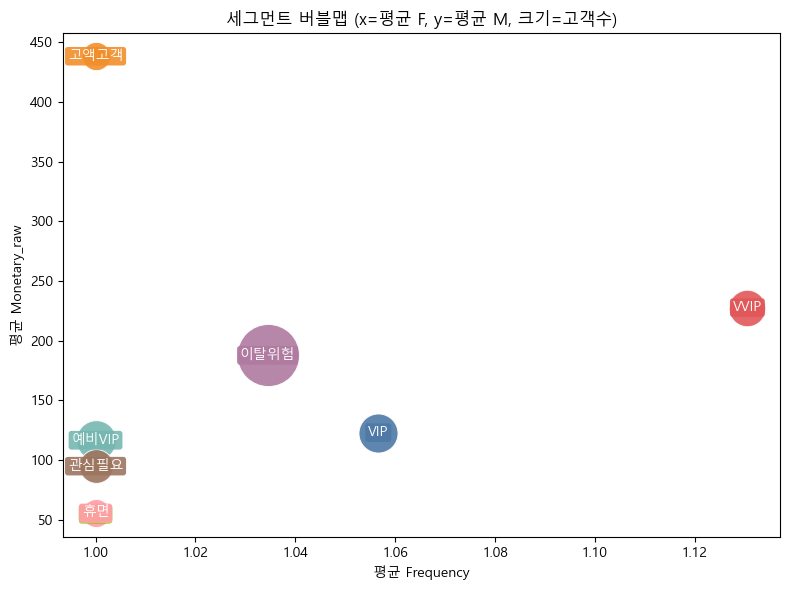

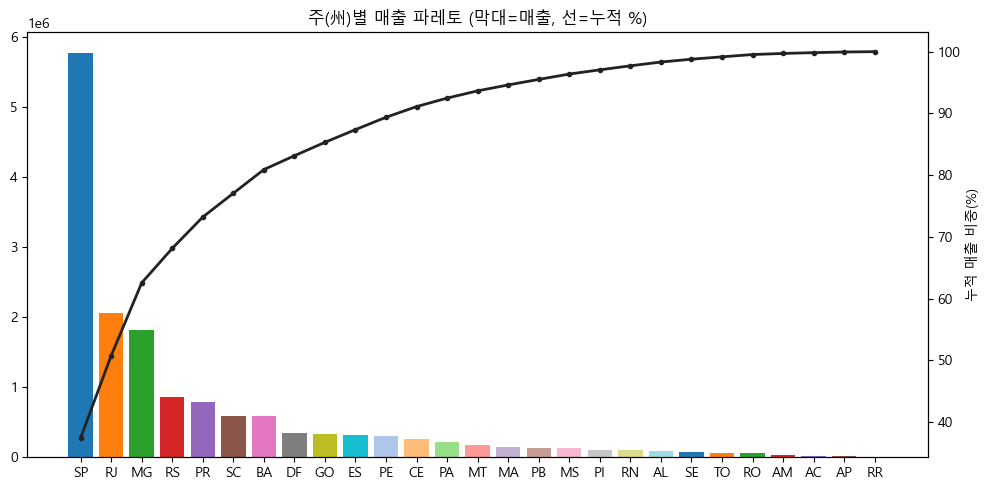

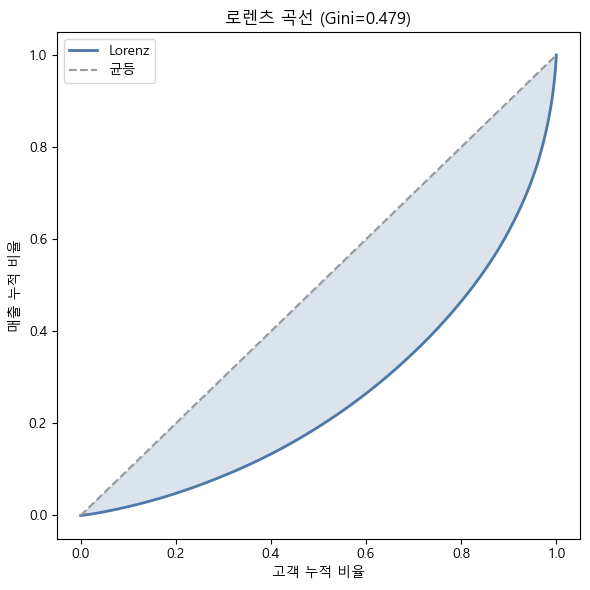

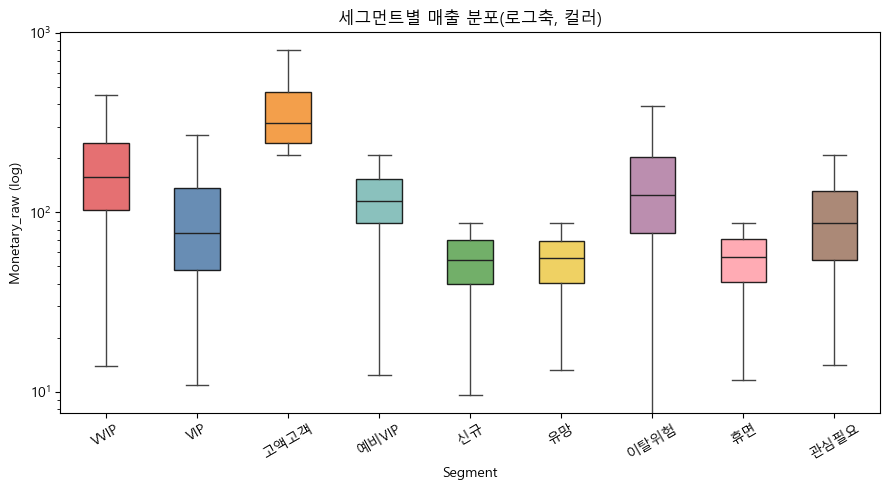

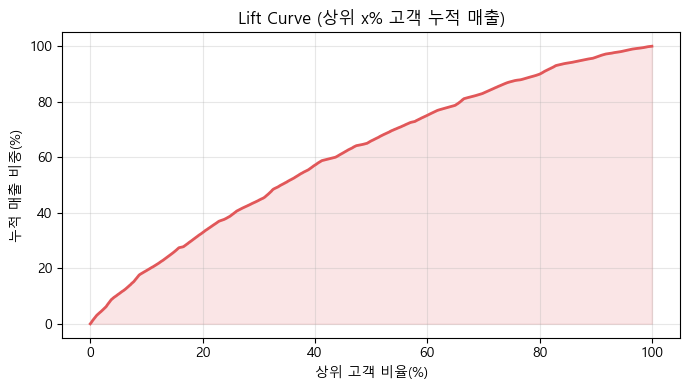

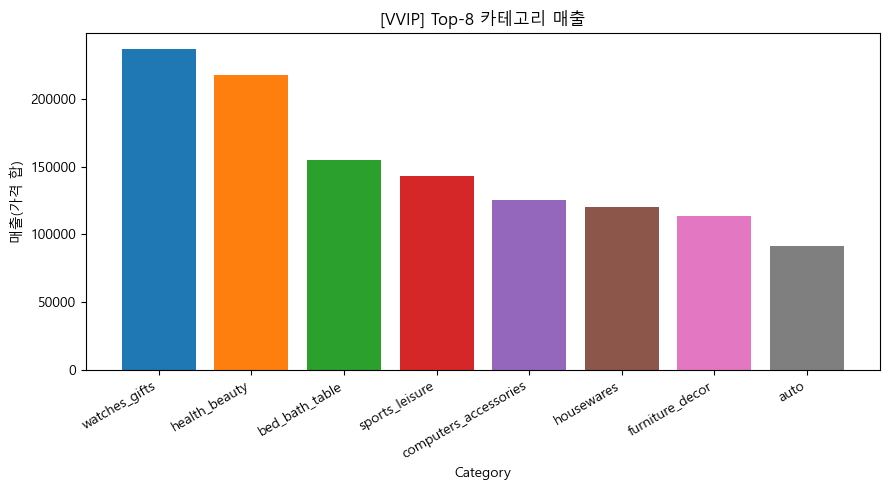

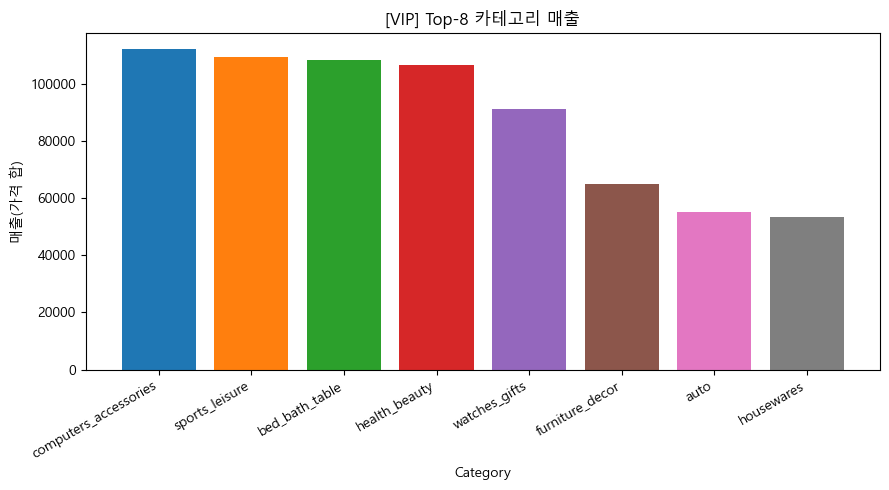

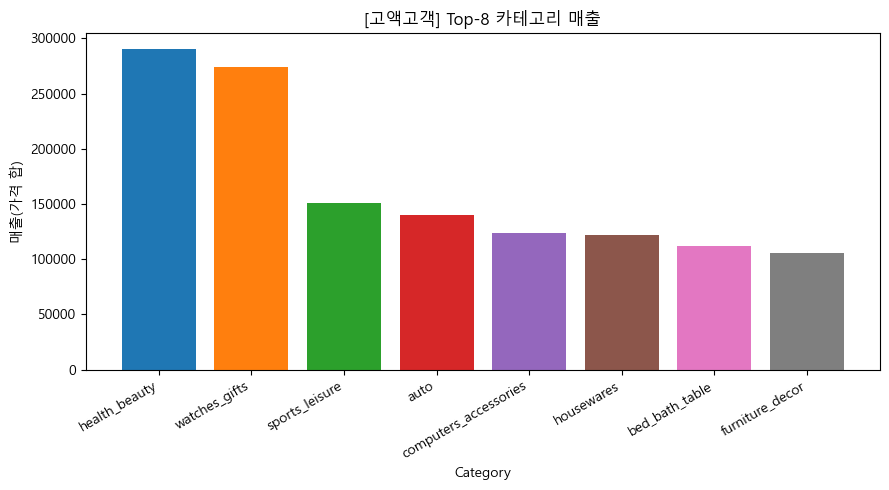

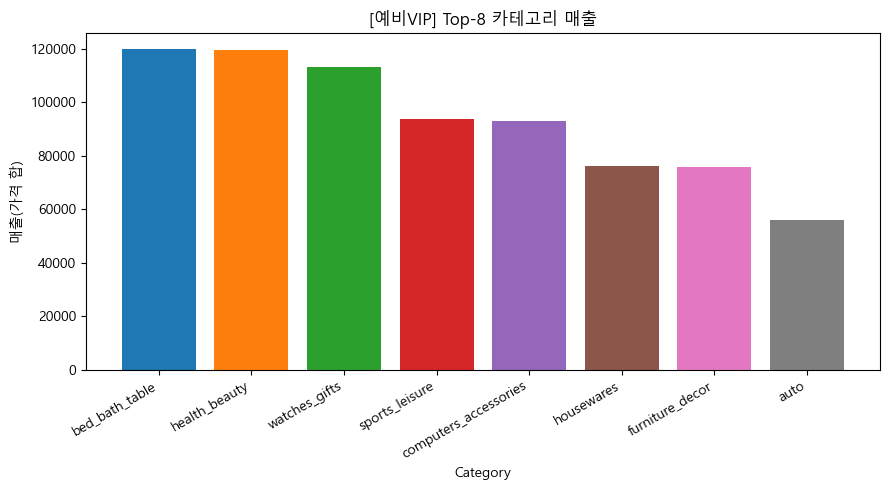

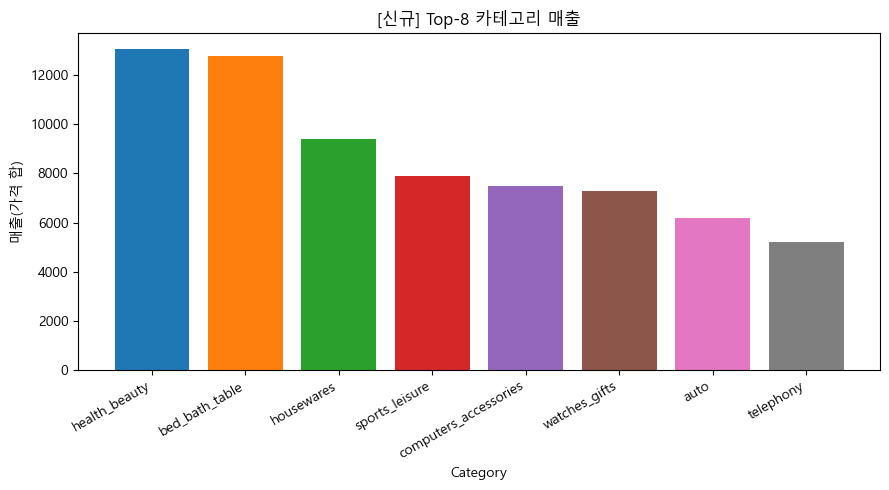

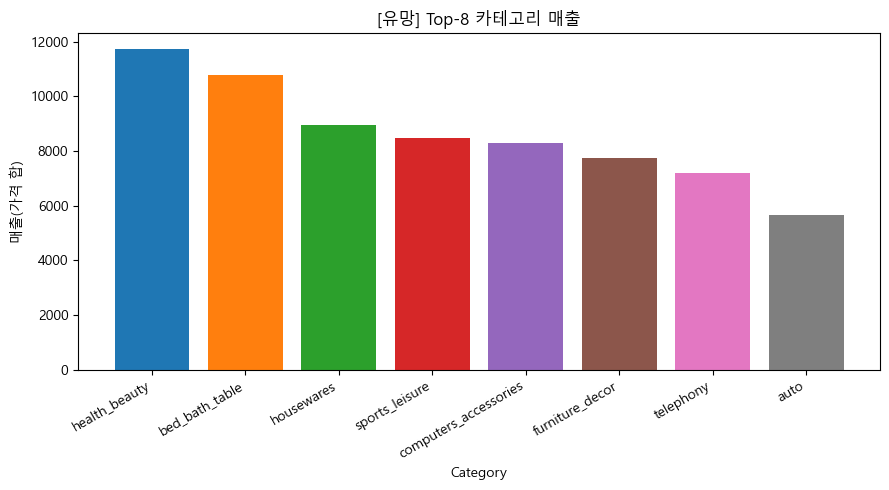

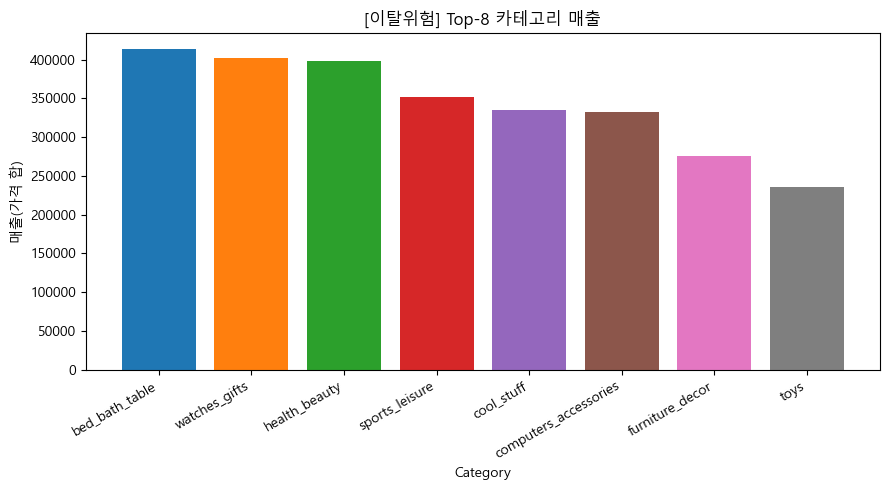

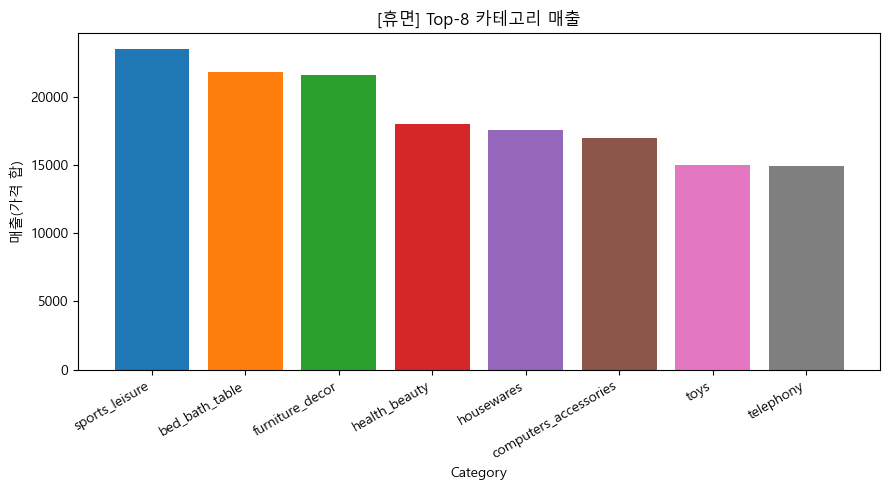

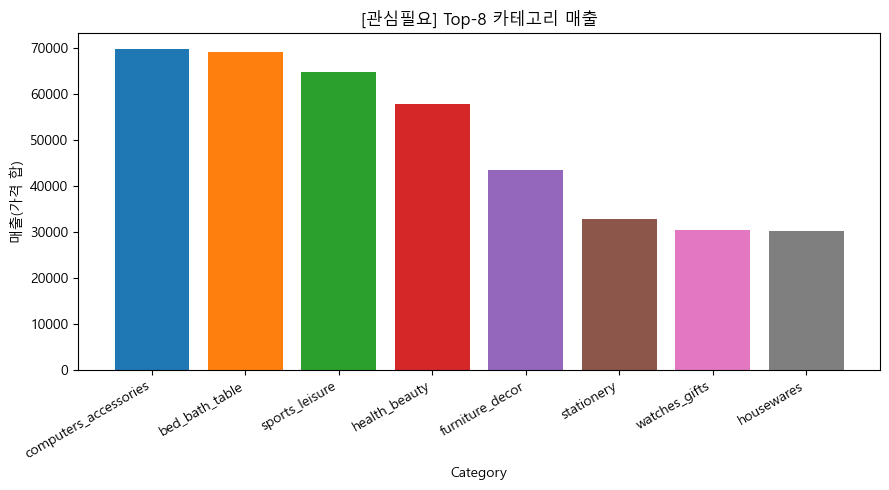

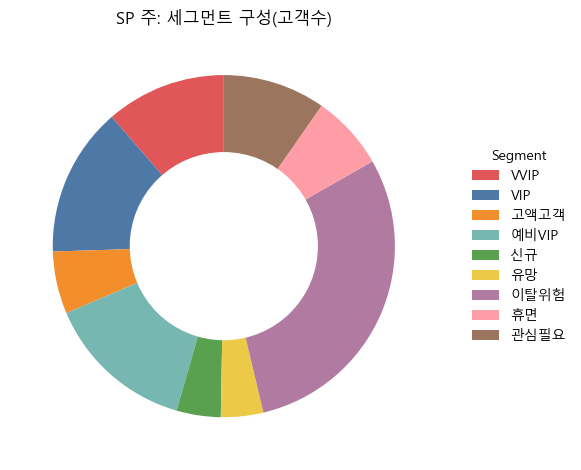

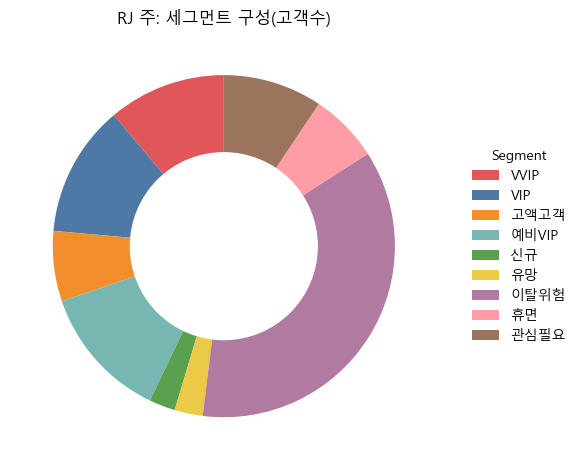

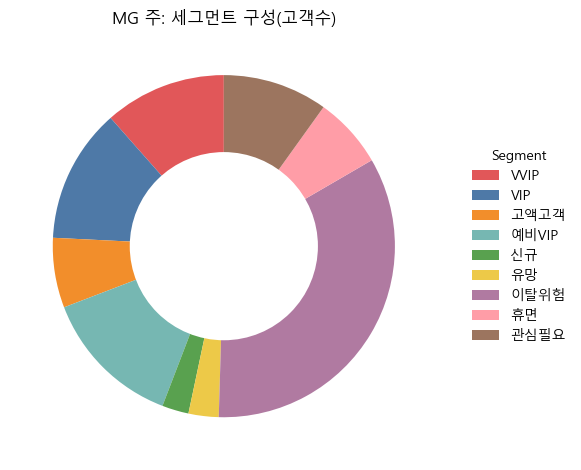

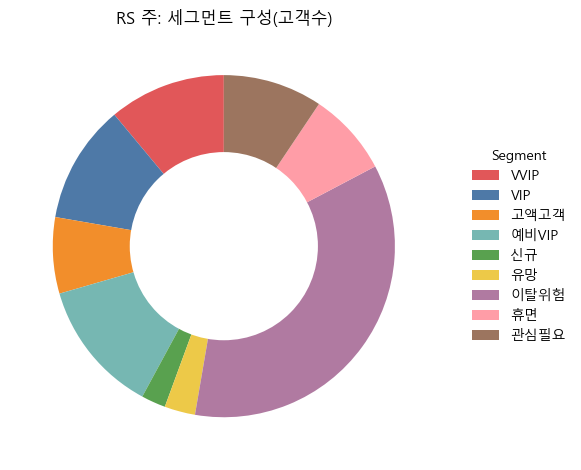

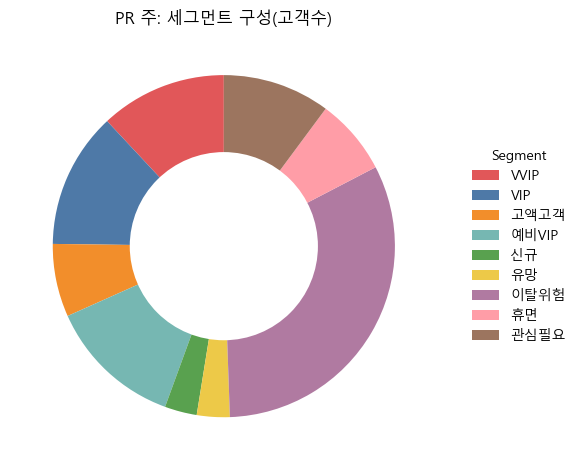

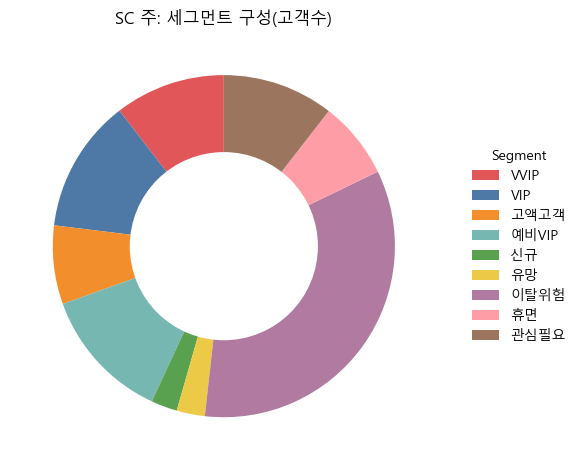

기준일(base) = 2018-08-29 / 최적 가중치: R=0.40, F=0.30, M=0.30  (단조충족: True)

[Class 요약]


,Class,고객수,매출액,매출비중(%)
0,1,18672,5062307,32.82
1,2,18671,3694223,23.95
2,3,18672,2857068,18.53
3,4,18671,2281526,14.79
4,5,18672,1527337,9.90



[세그먼트 요약]


,Segment,고객수,매출액,평균R,평균F,평균M,Recency_평균,Frequency_평균,Monetary_평균,매출비중(%)
1,VVIP,10578,2409676.90,4.620628,4.577236,3.744848,81.605029,1.130554,227.800804,15.62
0,VIP,12096,1488623.08,3.470899,4.441303,2.496941,182.498925,1.056630,123.067384,9.65
2,고액고객,6354,2785481.17,4.030689,2.004879,5.000000,134.331130,1.000000,438.382306,18.06
5,예비VIP,12485,1457135.47,4.500761,2.237085,3.002243,92.338807,1.000000,116.710891,9.45
4,신규,2948,161494.02,5.000000,1.507123,1.494912,45.450475,1.000000,54.780875,1.05
6,유망,2997,164862.88,4.000000,1.491491,1.501835,138.607608,1.000000,55.009303,1.07
7,이탈위험,30591,5746175.65,1.503841,3.294989,3.273446,396.442418,1.034455,187.838765,37.26
8,휴면,6261,349530.57,1.495608,1.500240,1.515732,398.462386,1.000000,55.826636,2.27
3,관심필요,9048,859482.03,3.000000,2.007294,2.483311,222.707560,1.000000,94.991383,5.57



[세그먼트 권장 액션]


,Segment,권장액션
0,VVIP,"VIP전용 혜택, 프리오더, 리퍼럴 보상, 멤버십 유지 인센티브, 고마진 번들"
1,VIP,"구독/정기배송, 교차판매, 기념일 쿠폰, 리뷰/UGC 유도"
2,고액고객,"프리미엄 업셀/애드온, 컨시어지 상담, 빠른/무료 배송, 한정판 초대"
3,예비VIP,"N+1 재구매 쿠폰, 온보딩 시리즈, 장바구니 리마인드, 적립금 만료알림"
4,신규,"웰컴 시리즈, 초보/사이즈 가이드, 첫 재구매 쿠폰, 간편반품 안내"
5,유망,"인기/시즌 추천, 소액 인센티브(배송비 쿠폰), 개인화 추천"
6,이탈위험,"윈백(강한 인센티브), 재입고/가격하락 알림, CS 이슈 점검"
7,휴면,"분기 리마인드, 1회성 리액티베이션 후 비반응 억제"
8,관심필요,"개인화 추천, 마이크로 인센티브, 콘텐츠 노출 확대"


In [40]:
# =========================================================
# 과제 1: 지역별 RFM + 세그먼트 + 시각화 (clean DF 사용, 추가 import 불필요)
# 필요 DF (메모리에 이미 존재): orders_clean, payments_clean, customers_clean
# 선택 DF (있으면 카테고리/도넛 차트 추가): order_items_clean, products_clean, category_tr_clean
# 세그먼트 명칭: VVIP, VIP, 사업자(구 빅스펜더), 예비VIP, 신규, 유망, 이탈위험, 휴면, 관심필요
# =========================================================

# ---- 가드 ----
_need = {"orders_clean","payments_clean","customers_clean"}
_missing = [x for x in _need if x not in globals()]
if _missing:
    raise NameError(f"다음 DataFrame이 필요합니다: {_missing}")

# ---- 1) RFM 베이스 (배송완료 주문 기준) ----
od = orders_clean.loc[orders_clean["order_status"]=="delivered",
                      ["order_id","customer_id","order_purchase_timestamp"]].dropna(subset=["order_purchase_timestamp"])
oc = customers_clean[["customer_id","customer_unique_id","customer_state"]]
od = od.merge(oc, on="customer_id", how="left")

_base_date = od["order_purchase_timestamp"].dt.date.max()
_last_dt = od.groupby("customer_unique_id")["order_purchase_timestamp"].max().dt.date
rfm_recency = (pd.to_datetime(_base_date) - pd.to_datetime(_last_dt)).dt.days + 1
rfm_recency.name = "Recency_days"

rfm_freq = od.groupby("customer_unique_id")["order_id"].nunique().rename("Frequency")

pay_per_order = payments_clean.groupby("order_id")["payment_value"].sum().rename("pay_sum")
od_pay = od.merge(pay_per_order, on="order_id", how="left")
rfm_m_raw = od_pay.groupby("customer_unique_id")["pay_sum"].sum().fillna(0.0).rename("Monetary_raw")

def _winsorize(s, lo=0.01, hi=0.99):
    x = pd.to_numeric(s, errors="coerce")
    ql, qh = x.quantile(lo), x.quantile(hi)
    return x.clip(ql, qh)

rfm_m = _winsorize(rfm_m_raw, 0.01, 0.99).rename("Monetary")
rfm_state = od.groupby("customer_unique_id")["customer_state"].first().rename("customer_state")

rfm = pd.concat([rfm_recency, rfm_freq, rfm_m_raw, rfm_m, rfm_state], axis=1).reset_index()

# ---- 2) 점수화 (R=하이브리드, F/M=5분위) ----
def _recency_hybrid_bins(rdays, round_to=5):
    x = pd.to_numeric(rdays, errors="coerce").dropna()
    qs = x.quantile([.2,.4,.6,.8]).values.tolist()
    qs_round = [int(round(v/round_to)*round_to) for v in qs]
    for i in range(1,len(qs_round)):
        if qs_round[i] <= qs_round[i-1]:
            qs_round[i] = qs_round[i-1] + round_to
    bins = [-np.inf] + qs_round + [np.inf]
    return bins, [5,4,3,2,1]  # 작을수록 최근 → 높은 점수

bins_r, labels_r = _recency_hybrid_bins(rfm["Recency_days"], 5)
rfm["R_score"] = pd.cut(rfm["Recency_days"], bins=bins_r, labels=labels_r, include_lowest=True).astype(int)

def _score_q5(s, labels=(1,2,3,4,5)):
    r = pd.to_numeric(s, errors="coerce").rank(method="first")
    return pd.qcut(r, q=len(labels), labels=labels).astype(int)

rfm["F_score"] = _score_q5(rfm["Frequency"], (1,2,3,4,5))
rfm["M_score"] = _score_q5(rfm["Monetary"],  (1,2,3,4,5))

_chk = rfm.loc[rfm["Recency_days"]==1, "R_score"]
if not _chk.empty and int(_chk.mode().iloc[0]) != 5:
    raise AssertionError("R_score 방향 오류: Recency_days=1 고객의 R_score는 5여야 합니다.")

# ---- 3) 가중치 최적화 (제약: R ≥ F ≥ M, 합=1) ----
def _class_from_scores(scores, q=5):
    ranks = pd.Series(scores).rank(method="first", ascending=False)
    return pd.qcut(ranks, q, labels=list(range(1,q+1))).astype(int)

def _is_nondecreasing_down(arr):
    return np.all(np.diff(arr) <= 1e-12)  # 1→5로 갈수록 비중 감소

def _opt_weights(rfm_df, step=0.05,
                 a_rng=(0.35,0.60), b_rng=(0.20,0.45), c_rng=(0.10,0.30)):
    R = rfm_df["R_score"].to_numpy(float)
    F = rfm_df["F_score"].to_numpy(float)
    M = rfm_df["M_score"].to_numpy(float)
    Y = rfm_df["Monetary_raw"].to_numpy(float)

    A = np.round(np.arange(a_rng[0], a_rng[1]+1e-9, step), 2)
    B = np.round(np.arange(b_rng[0], b_rng[1]+1e-9, step), 2)

    best = None
    best_obj = -1e9
    for a in A:
        for b in B:
            c = float(np.round(1 - a - b, 2))
            if c < c_rng[0] or c > c_rng[1]: 
                continue
            if not (a >= b >= c):
                continue
            S = a*R + b*F + c*M
            # 순위 상관 근사 (scipy 없이 rank-corr 유사치)
            r_rank = pd.Series(S).rank(method="first")
            y_rank = pd.Series(Y).rank(method="first")
            sp_like = float(np.corrcoef(r_rank, y_rank)[0,1])

            k = max(1, int(len(S)*0.20))
            top = np.argsort(-S)[:k]
            lift20 = float(Y[top].sum() / Y.sum()) if Y.sum() > 0 else 0.0

            cls = _class_from_scores(S, 5)
            share = (rfm_df["Monetary_raw"].groupby(cls).sum() / rfm_df["Monetary_raw"].sum()).reindex([1,2,3,4,5]).fillna(0.0).to_numpy()
            mono = _is_nondecreasing_down(share)

            obj = 0.6*sp_like + 0.4*lift20 + (0.02 if mono else 0.0)
            if obj > best_obj:
                best_obj = obj
                best = (a,b,c, sp_like, lift20, share, mono)
    if best is None:
        return {"alpha":0.4,"beta":0.35,"gamma":0.25,"spearman_like":np.nan,"lift20":np.nan,"share":np.array([np.nan]*5)}
    a,b,c,sp_like,l20,share,mono = best
    return {"alpha":a,"beta":b,"gamma":c,"spearman_like":sp_like,"lift20":l20,"share":share,"mono":mono}

_best = _opt_weights(rfm, step=0.05)
a,b,c = _best["alpha"], _best["beta"], _best["gamma"]

rfm["WeightedScore"] = a*rfm["R_score"] + b*rfm["F_score"] + c*rfm["M_score"]
rfm["Class"] = _class_from_scores(rfm["WeightedScore"], 5)  # 1=최상, 5=최하

# ---- 4) 세그먼트 라벨 (빅스펜더 → '고액고객') ----
def _segment(row):
    R,F,M,cls = int(row["R_score"]), int(row["F_score"]), int(row["M_score"]), int(row["Class"])
    if (cls==1) and (R>=4) and (F>=4): return "VVIP"
    if (F>=4) and (R>=3):              return "VIP"
    if (M==5) and (R>=3):              return "고액고객"     
    if (R>=4) and (F>=3 or M>=3):      return "예비VIP"
    if (R==5) and (F<=2):              return "신규"
    if (R>=4) and (F<=2) and (M<=3):   return "유망"
    if (R<=2) and (F>=3 or M>=3):      return "이탈위험"
    if (R<=2) and (F<=2) and (M<=2):   return "휴면"
    return "관심필요"

rfm["Segment"] = rfm.apply(_segment, axis=1)

segment_actions = {
    "VVIP":"VIP전용 혜택, 프리오더, 리퍼럴 보상, 멤버십 유지 인센티브, 고마진 번들",
    "VIP":"구독/정기배송, 교차판매, 기념일 쿠폰, 리뷰/UGC 유도",
    "고액고객":"프리미엄 업셀/애드온, 컨시어지 상담, 빠른/무료 배송, 한정판 초대",
    "예비VIP":"N+1 재구매 쿠폰, 온보딩 시리즈, 장바구니 리마인드, 적립금 만료알림",
    "신규":"웰컴 시리즈, 초보/사이즈 가이드, 첫 재구매 쿠폰, 간편반품 안내",
    "유망":"인기/시즌 추천, 소액 인센티브(배송비 쿠폰), 개인화 추천",
    "이탈위험":"윈백(강한 인센티브), 재입고/가격하락 알림, CS 이슈 점검",
    "휴면":"분기 리마인드, 1회성 리액티베이션 후 비반응 억제",
    "관심필요":"개인화 추천, 마이크로 인센티브, 콘텐츠 노출 확대"
}
segment_actions_df = pd.DataFrame(list(segment_actions.items()), columns=["Segment","권장액션"])

# ---- 5) 요약 테이블 ----
class_summary = (rfm.groupby("Class", as_index=False)
                   .agg(고객수=("customer_unique_id","nunique"),
                        매출액=("Monetary_raw","sum"))
                   .sort_values("Class"))
_tot = float(class_summary["매출액"].sum())
class_summary["매출비중(%)"] = np.where(_tot>0, (class_summary["매출액"]/_tot*100).round(2), 0.0)
class_summary["매출액"] = class_summary["매출액"].round(0).astype(int)

seg_order = ["VVIP","VIP","고액고객","예비VIP","신규","유망","이탈위험","휴면","관심필요"]
segment_summary = (rfm.groupby("Segment")
                     .agg(고객수=("customer_unique_id","nunique"),
                          매출액=("Monetary_raw","sum"),
                          평균R=("R_score","mean"),
                          평균F=("F_score","mean"),
                          평균M=("M_score","mean"),
                          Recency_평균=("Recency_days","mean"),
                          Frequency_평균=("Frequency","mean"),
                          Monetary_평균=("Monetary_raw","mean"))
                     .reset_index())
segment_summary["매출비중(%)"] = (segment_summary["매출액"]/segment_summary["매출액"].sum()*100).round(2)
segment_summary["Segment"] = pd.Categorical(segment_summary["Segment"], categories=seg_order, ordered=True)
segment_summary = segment_summary.sort_values("Segment")

# ---- 6) 지역(주)별 파레토 준비 ----
state_sales = rfm.groupby("customer_state")["Monetary_raw"].sum().sort_values(ascending=False)
state_df = state_sales.reset_index().rename(columns={"Monetary_raw":"sales"})
state_df["cum_share"] = (state_df["sales"].cumsum()/state_df["sales"].sum())*100

# ---- 7) 팔레트/색상(세그먼트/카테고리) ----
seg_colors = {
    "VVIP":      "#E15759",
    "VIP":       "#4E79A7",
    "고액고객":     "#F28E2B",  
    "예비VIP":   "#76B7B2",
    "신규":      "#59A14F",
    "유망":      "#EDC948",
    "이탈위험":   "#B07AA1",
    "휴면":      "#FF9DA7",
    "관심필요":   "#9C755F",
}
present_segments = [s for s in seg_order if s in rfm["Segment"].unique()]

_cat_palette = np.array([
    "#1f77b4","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f",
    "#bcbd22","#17becf","#aec7e8","#ffbb78",
    "#98df8a","#ff9896","#c5b0d5","#c49c94",
    "#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"
])
def _get_cat_colors(n):
    reps = int(np.ceil(n / len(_cat_palette)))
    return list(np.tile(_cat_palette, reps)[:n])

# ---- 8) 시각화 (컬러풀) ----
# (1) 세그먼트 버블맵
_seg = (rfm.groupby("Segment")
          .agg(avgF=("Frequency","mean"),
               avgM=("Monetary_raw","mean"),
               n=("customer_unique_id","nunique"))
          .reset_index())
_seg = _seg[_seg["Segment"].isin(present_segments)].copy()
_seg["Segment"] = pd.Categorical(_seg["Segment"], categories=seg_order, ordered=True)
_seg = _seg.sort_values("Segment")

plt.figure(figsize=(8,6))
sizes = (_seg["n"]/_seg["n"].max()*2000).clip(80, 2200).values
for i, r in _seg.reset_index(drop=True).iterrows():
    plt.scatter(r["avgF"], r["avgM"], s=sizes[i],
                color=seg_colors.get(r["Segment"], "#333333"), alpha=0.9, edgecolor="white", linewidth=0.7)
    plt.text(r["avgF"], r["avgM"], r["Segment"], ha="center", va="center", fontsize=10, color="white",
             bbox=dict(boxstyle="round,pad=0.2", fc=seg_colors.get(r["Segment"], "#333333"), ec="none", alpha=0.9))
plt.title("세그먼트 버블맵 (x=평균 F, y=평균 M, 크기=고객수)")
plt.xlabel("평균 Frequency"); plt.ylabel("평균 Monetary_raw")
plt.tight_layout(); plt.show()

# (2) 주(州)별 파레토 차트
plt.figure(figsize=(10,5))
plt.bar(state_df["customer_state"], state_df["sales"], color=_get_cat_colors(len(state_df)))
ax2 = plt.twinx()
ax2.plot(state_df["customer_state"], state_df["cum_share"], color="#222222", linewidth=2.0, marker="o", markersize=3)
plt.title("주(州)별 매출 파레토 (막대=매출, 선=누적 %)")
plt.xlabel("State"); plt.xticks(rotation=30)
plt.ylabel("매출")
ax2.set_ylabel("누적 매출 비중(%)")
plt.tight_layout(); plt.show()

# (3) 로렌츠 곡선 & 지니계수
vals = np.sort(rfm["Monetary_raw"].to_numpy())
vals = vals[~np.isnan(vals)]
if vals.size > 0 and vals.sum() > 0:
    cum_vals = np.cumsum(vals)
    lorenz = np.insert(cum_vals, 0, 0)/cum_vals[-1]
    x = np.linspace(0.0, 1.0, lorenz.size)
    gini = 1 - 2*np.trapz(lorenz, x)
    plt.figure(figsize=(6,6))
    plt.plot(x, lorenz, label="Lorenz", color="#4E79A7", linewidth=2)
    plt.fill_between(x, lorenz, x, color="#4E79A7", alpha=0.2)
    plt.plot([0,1],[0,1], linestyle="--", color="#999999", label="균등")
    plt.title(f"로렌츠 곡선 (Gini={gini:.3f})")
    plt.xlabel("고객 누적 비율"); plt.ylabel("매출 누적 비율")
    plt.legend(); plt.tight_layout(); plt.show()

# (4) 세그먼트별 매출 박스플롯(로그축)
labels = [s for s in seg_order if s in rfm["Segment"].unique()]
data = [rfm.loc[rfm["Segment"]==s, "Monetary_raw"].dropna().values for s in labels]
plt.figure(figsize=(9,5))
bp = plt.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, lab in zip(bp["boxes"], labels):
    patch.set_facecolor(seg_colors.get(lab, "#888888"))
    patch.set_alpha(0.85)
for whisker in bp["whiskers"]: whisker.set_color("#444444")
for cap in bp["caps"]:         cap.set_color("#444444")
for median in bp["medians"]:   median.set_color("#222222")
plt.yscale("log")
plt.title("세그먼트별 매출 분포(로그축, 컬러)")
plt.xlabel("Segment"); plt.ylabel("Monetary_raw (log)")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

# (5) Lift Curve
idx = np.argsort(-rfm["WeightedScore"].to_numpy())
mon_sorted = rfm["Monetary_raw"].to_numpy()[idx]
if mon_sorted.sum() > 0:
    cum = np.cumsum(mon_sorted)/mon_sorted.sum()
    x = np.linspace(1/len(cum), 1.0, len(cum))*100
    plt.figure(figsize=(7,4))
    plt.plot(x, cum*100, color="#E15759", linewidth=2)
    plt.fill_between(x, cum*100, color="#E15759", alpha=0.15)
    plt.title("Lift Curve (상위 x% 고객 누적 매출)")
    plt.xlabel("상위 고객 비율(%)"); plt.ylabel("누적 매출 비중(%)")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ---- 9) (선택) 세그먼트별 Top-N 카테고리 바차트 ----
_need_cat = {"order_items_clean", "products_clean", "category_tr_clean"}
_miss_cat = [x for x in _need_cat if x not in globals()]
if _miss_cat:
    print(f"⚠️ (세그먼트×카테고리)용 DataFrame 없음: {_miss_cat} — 이 부분만 건너뜁니다.")
else:
    # category_en 보장
    if "category_en" not in products_clean.columns:
        cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
        products_clean = products_clean.copy()
        products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

    oc2 = orders_clean.merge(
        customers_clean[["customer_id","customer_unique_id"]], on="customer_id", how="left"
    ).merge(
        rfm[["customer_unique_id","Segment"]], on="customer_unique_id", how="left"
    )
    delivered_ids = oc2.loc[oc2["order_status"]=="delivered", ["order_id","Segment"]]

    oi = order_items_clean.merge(products_clean[["product_id","category_en"]], on="product_id", how="left")
    oi["category_en"] = oi["category_en"].fillna("unknown")
    oi["price"] = pd.to_numeric(oi["price"], errors="coerce")

    oi_seg = oi.merge(delivered_ids, on="order_id", how="inner")

    seg_cat = (oi_seg.groupby(["Segment","category_en"])["price"].sum()
                     .reset_index().rename(columns={"price":"sales"}))

    TOPN = 8
    for seg in present_segments:
        d = seg_cat[seg_cat["Segment"]==seg].sort_values("sales", ascending=False).head(TOPN)
        if d.empty: 
            continue
        colors = _get_cat_colors(len(d))
        plt.figure(figsize=(9,5))
        plt.bar(d["category_en"], d["sales"], color=colors)
        plt.title(f"[{seg}] Top-{TOPN} 카테고리 매출")
        plt.xlabel("Category"); plt.ylabel("매출(가격 합)")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout(); plt.show()

# ---- 10) (선택) Top-K 주 도넛 차트 ----
K = 6
top_states = state_df.head(K)["customer_state"].tolist()
for st in top_states:
    d = rfm.loc[rfm["customer_state"]==st].groupby("Segment")["customer_unique_id"].nunique()
    d = d.reindex(present_segments).fillna(0)
    if d.sum() == 0:
        continue
    wedges, _texts = plt.pie(d.values,
                             startangle=90,
                             colors=[seg_colors.get(s, "#777777") for s in d.index])
    centre = plt.Circle((0,0), 0.55, fc="white")
    plt.gca().add_artist(centre)
    plt.title(f"{st} 주: 세그먼트 구성(고객수)")
    plt.legend(wedges, d.index, title="Segment", bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=False)
    plt.tight_layout(); plt.show()

# ---- 11) 핵심 표 출력 ----
print(f"기준일(base) = {_base_date} / 최적 가중치: R={a:.2f}, F={b:.2f}, M={c:.2f}  (단조충족: {_best['mono']})")
print("\n[Class 요약]")
display(class_summary)
print("\n[세그먼트 요약]")
display(segment_summary)
print("\n[세그먼트 권장 액션]")
display(segment_actions_df)


1) 세그먼트 버블맵

VVIP가 가장 우상단(높은 F·M)에 위치해 핵심 매출원이며, VIP는 규모 대비 객단가가 중간 수준.

이탈위험은 버블이 커서 규모는 큰데 최근성/빈도 신호가 약해짐 → 윈백 타깃 1순위.

예비VIP/관심필요/휴면은 좌하단에 몰려 AOV·재구매 모두 낮음 → 온보딩/재구매 유도 필요.

라벨에 보이는 ‘고액고객’(=사업자 의도라면 라벨 교체 권장) 은 F는 낮지만 M이 매우 커 프리미엄/대량구매 프로그램 적합.

2) 주(州)별 매출 파레토

SP 단일 주가 전체 매출의 **약 35–40%**를 차지하며, SP+RJ로 **60–70%**까지 누적.

상위 5개 주 합산이 **80–90%**에 근접해 매출이 특정 권역에 집중되어 있음.

상위 주에는 물류 SLA/재고/광고 예산을 우선 배분하고, 후순위 주는 지역 특화 카테고리/프로모션으로 보완.

지역 편중이 크므로 주 단위 세그먼트 믹스를 더 세분화해 운영 전략을 차별화하는 것이 효과적.

3) 로렌츠 곡선 (Gini = 0.479)

지니계수 0.48 내외로 중간 이상 수준의 고객 매출 집중도가 확인됨.

상위 고객 관리(예: VVIP/VIP/사업자 대상 락인, 멤버십, 프리오더, 전용 CS)로 ROI 극대화 가능.

동시에 중하위군(예비VIP/관심필요/신규)엔 마이크로 인센티브·콘텐츠 온보딩으로 풀을 키워야 함.

리프트 커브와 함께 **상위 x% 컷오프(예: 20% 타깃)**를 CRM 집행 기준으로 쓰면 좋음.

In [41]:
# === 1) 번들로 저장 (권장: Pickle) ===
import os, pickle

# 저장 폴더
SNAP_DIR = "_snapshots"
os.makedirs(SNAP_DIR, exist_ok=True)

# 번들 구성 (요청하신 9개 DF)
bundle = {
    "orders_clean": orders_clean,
    "order_items_clean": order_items_clean,
    "payments_clean": payments_clean,
    "reviews_clean": reviews_clean,
    "customers_clean": customers_clean,
    "geolocation_clean": geolocation_clean,
    "products_clean": products_clean,
    "sellers_clean": sellers_clean,
    "category_tr_clean": category_tr_clean,
}

# 저장
BUNDLE_PATH = os.path.join(SNAP_DIR, "olist_clean_bundle.pkl")
with open(BUNDLE_PATH, "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Saved bundle ->", BUNDLE_PATH)
print({k: v.shape for k, v in bundle.items()})

✅ Saved bundle -> _snapshots\olist_clean_bundle.pkl
{'orders_clean': (99441, 9), 'order_items_clean': (112650, 9), 'payments_clean': (103877, 6), 'reviews_clean': (99224, 7), 'customers_clean': (99441, 5), 'geolocation_clean': (1000163, 5), 'products_clean': (32951, 10), 'sellers_clean': (3095, 4), 'category_tr_clean': (71, 2)}
